# Market Anomalies

In these notebooks I will be looking into different market anomalies and testing basic investing strategies revolving around these anomalies.

## 1. Value Effect:

This anomaly is based on the tendency for stocks with low price to earnings ratios to outperform other stocks.

I will be using stocks in the S&P 500, ranking on E/P ratio and investing in the top 10% where the investments will be weighted by the E/P ratio and traded at the end of every month.

In [252]:
import wrds
import yfinance
import pandas as pd
import matplotlib.pyplot as plt

conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [95]:
start_date = '2010-12-31'
end_date = '2023-11-30'

dates = pd.date_range(start=start_date, end=end_date, freq='ME')

dates_list = dates.tolist()
dates_list.append(pd.to_datetime('2023-12-29'))

def fetch_sp500_constituents(date):
    query = f"""
      select * 
      from crsp.dsp500list 
      where start<='{date}'
      and ending>='{date}'
    """
    return conn.raw_sql(query)

constituents = {date: fetch_sp500_constituents(date) for date in dates_list}

In [47]:
def fetch_market_cap_batch(permnos, date):
    permnos_str = ','.join(map(str, permnos))
    query = f"""
    SELECT permno, cusip, date, prc, shrout
    FROM (
        SELECT permno, cusip, date, prc, shrout,
               RANK() OVER (PARTITION BY permno ORDER BY date DESC) as rank
        FROM crsp.dsf
        WHERE permno IN ({permnos_str}) AND date <= '{date}'
    ) ranked
    WHERE rank = 1
    ORDER BY permno, date DESC
    """
    return conn.raw_sql(query)

market_cap_data = []
for date in dates_list:
    permnos = constituents[date]['permno'].tolist()
    market_cap_data.append(fetch_market_cap_batch(permnos, date))

In [81]:
def fetch_earnings_batch(permnos, date):
    permnos_str = ','.join(map(str, permnos))
    query = f"""
    SELECT distinct left(cusip, 8) as cusip, lpermno, datadate, epspxq, datafmt, exchg, conm
    FROM (
        SELECT a.cusip, a.datadate, a.epspxq, b.lpermno, datafmt, exchg, conm,
               RANK() OVER (PARTITION BY b.lpermno ORDER BY a.datadate DESC) as rank
        FROM comp.fundq as a
        JOIN (SELECT cusip, lpermno FROM crsp.ccm_lookup WHERE lpermno IN ({permnos_str})) as b on a.cusip = b.cusip
        WHERE a.datadate <= '{date}'
        AND a.epspxq IS NOT NULL
        AND datafmt = 'STD'
    ) ranked
    WHERE rank = 1
    ORDER BY lpermno, datadate DESC
    """

    return conn.raw_sql(query)

earnings_data = []
for date in dates_list:
    permnos = constituents[date]['permno'].tolist()
    earnings_data.append(fetch_earnings_batch(permnos, date))

In [82]:
monthly_data = []

for i in range(len(earnings_data)):
    market_cap_data[i]['market_cap'] =  market_cap_data[i]['prc'] * market_cap_data[i]['shrout'] * 1000
    
    combined_data = pd.merge(earnings_data[i], market_cap_data[i], on= 'cusip')

    combined_data['E/P'] = combined_data['epspxq'] / combined_data['prc']

    monthly_data.append(combined_data)

In [315]:
monthly_company_portfolio = {}

for i in range(len(dates_list)):
    monthly_data[i]['Value_Score'] = monthly_data[i]['E/P'].rank(ascending=False) 
    top_value_stocks = monthly_data[i].nsmallest(25, 'Value_Score')
    top_value_stocks['Weights'] = top_value_stocks['E/P']/ top_value_stocks['E/P'].sum()
    date = dates_list[i]

    monthly_company_portfolio[date] = top_value_stocks

In [316]:
def fetch_monthly_returns(permnos, start_date, end_date):
    permnos_str = ','.join(map(str, permnos))
    query = f"""
    SELECT date, permno, ret
    FROM crsp.dsf
    WHERE permno IN ({permnos_str}) AND date BETWEEN '{start_date}' AND '{end_date}'
    """
    return conn.raw_sql(query)


returns_data = []
for date in dates_list:
    permnos = monthly_company_portfolio[date]['permno'].tolist()

    monthly_returns = fetch_monthly_returns(permnos, date + pd.DateOffset(days=1), (date + pd.DateOffset(months=1)) - pd.DateOffset(days=1))
    monthly_returns = pd.merge(monthly_returns, monthly_company_portfolio[date][['permno', 'Weights']], on='permno')
    monthly_returns['weighted_returns'] = monthly_returns['ret'] * monthly_returns['Weights']

    daily_returns = monthly_returns.groupby('date')['weighted_returns'].sum().reset_index()

    returns_data.append(daily_returns)

returns_df = pd.concat(returns_data)

returns_df['cumulative_return'] = (1 + returns_df['weighted_returns']).cumprod() - 1

C:\Users\Maxim\AppData\Local\Temp\ipykernel_76168\1279761969.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  returns_df = pd.concat(returns_data)


In [317]:
returns_df

,date,weighted_returns,cumulative_return
0,2011-01-03,0.015804,0.015804
1,2011-01-04,-0.006987,0.008706
2,2011-01-05,0.020143,0.029024
3,2011-01-06,-0.001447,0.027535
4,2011-01-07,0.000065,0.027603
...,...,...,...
15,2023-12-22,-0.000775,13.315447
16,2023-12-26,0.002960,13.357815
17,2023-12-27,-0.002284,13.325016
18,2023-12-28,-0.000555,13.317065


In [318]:
query = f"""
SELECT 
    caldt AS date, 
    vwretd AS daily_return
FROM 
    crsp.dsp500
WHERE 
    caldt BETWEEN '{dates_list[0] + pd.DateOffset(days=1)}' AND '{dates_list[-1]}'
ORDER BY 
    caldt;
"""
sp_returns = conn.raw_sql(query)

In [319]:
sp_returns['date'] = pd.to_datetime(sp_returns['date'])

sp_returns['cumulative_return'] = (1 + sp_returns['daily_return']).cumprod() - 1

In [313]:
sp_returns

,date,daily_return,cumulative_return
0,2011-01-03,0.011325,0.011325
1,2011-01-04,-0.001236,0.010075
2,2011-01-05,0.005164,0.015291
3,2011-01-06,-0.001715,0.013550
4,2011-01-07,-0.001755,0.011771
...,...,...,...
3265,2023-12-22,0.001708,3.857202
3266,2023-12-26,0.004208,3.877642
3267,2023-12-27,0.001604,3.885465
3268,2023-12-28,0.000415,3.887493


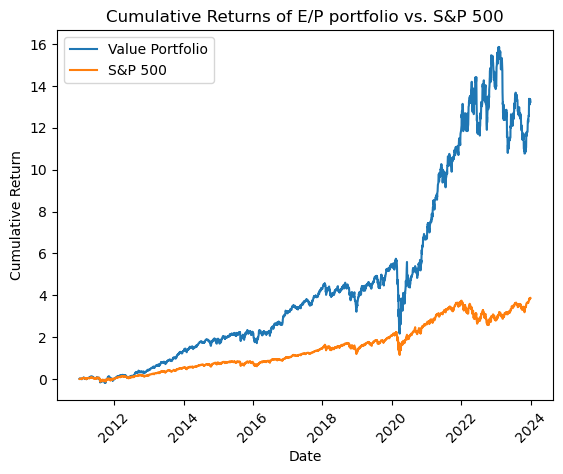

In [320]:
plt.plot(returns_df['date'], returns_df['cumulative_return'])
plt.plot(sp_returns['date'], sp_returns['cumulative_return'])
plt.title('Cumulative Returns of E/P portfolio vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.legend(['Value Portfolio', 'S&P 500'])
plt.show()

This seems surprisingly good (maybe too good) but I'm not sure what could be incorrect, I tested the method itself on single companies so my only guess is it has to do with the rebalancing every month but even when looking into that there don't appear to be large jumps between months which I'd expect if there was an issue with that. 

It looks like this strategy works quite well during bull markets but during bear markets may struggle. 

Next it would be interesting to try and take advantage of two market anomalies, both this value effect and the size effect. In order to do this I'll follow the same structure but instead of using companies from the S&P 500 I will look at companies in the Russell 2000.